In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import wesanderson as wes

In [77]:
df = pd.read_csv("./data/exp_002/rosenbrock_n1_3_n2_1_mu_1_a_5e-02_b_5/summary.csv")

In [78]:
df.columns

Index(['sampler', 'target_accept_prob', 'trial', 'true_accept_rate', 'ks',
       'ks_max', 'ad', 'ad_max', 'ess', 'ess_min', 'ess_median', 'ess_max'],
      dtype='object')

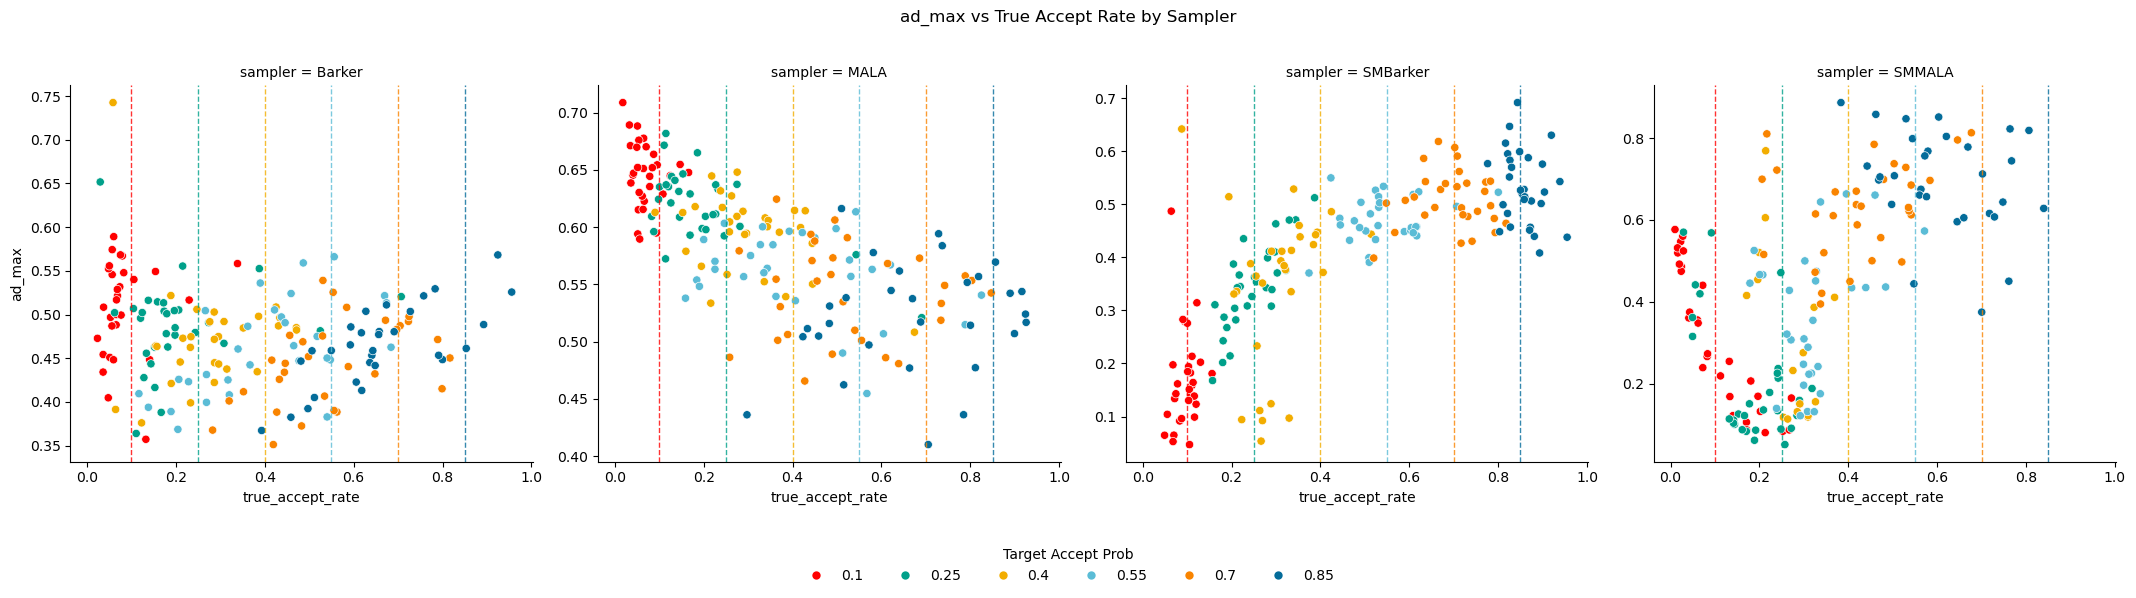

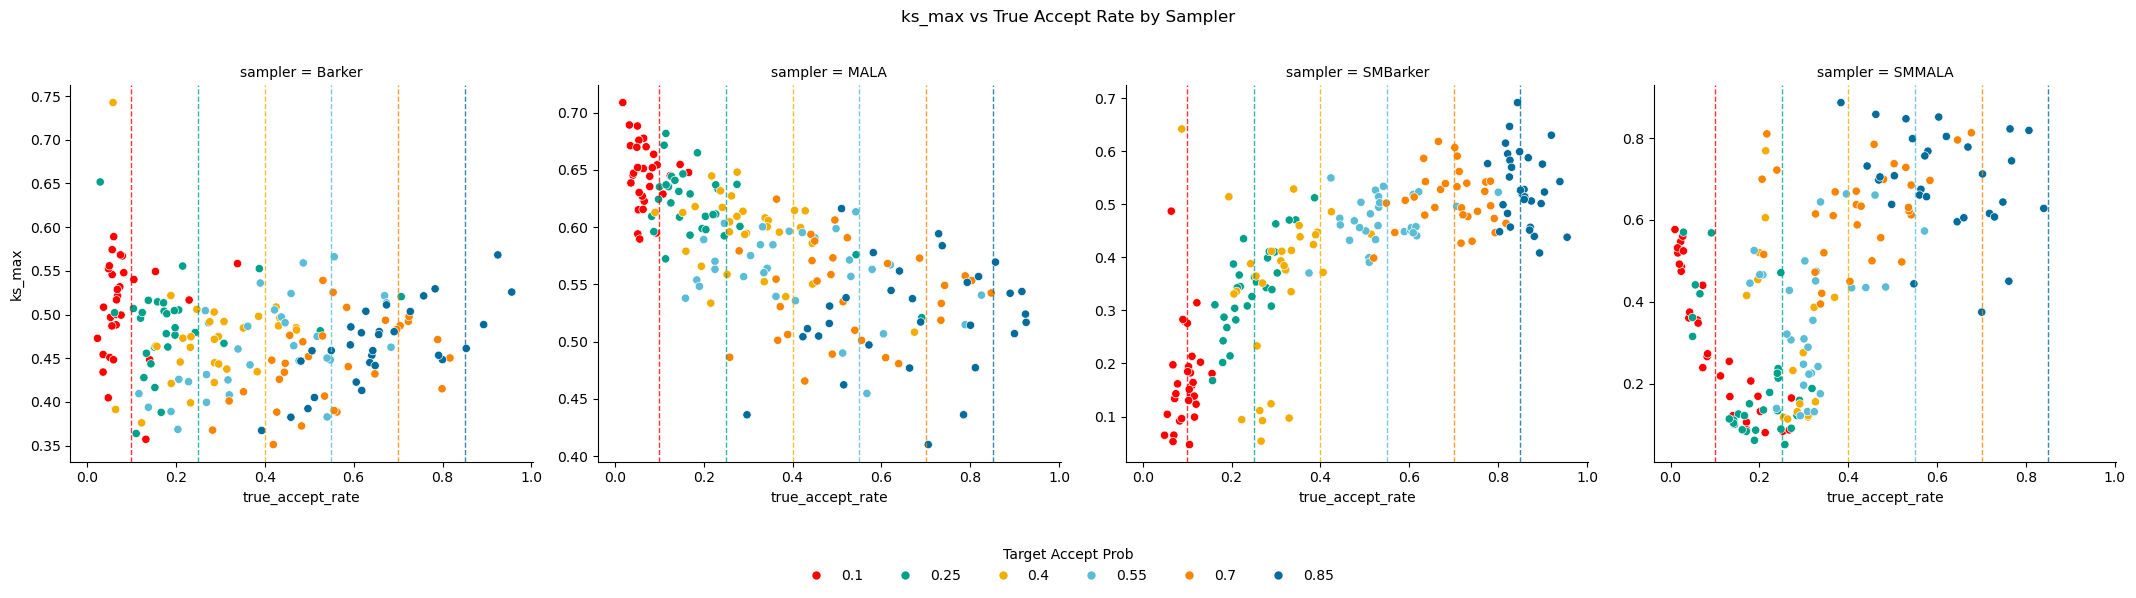

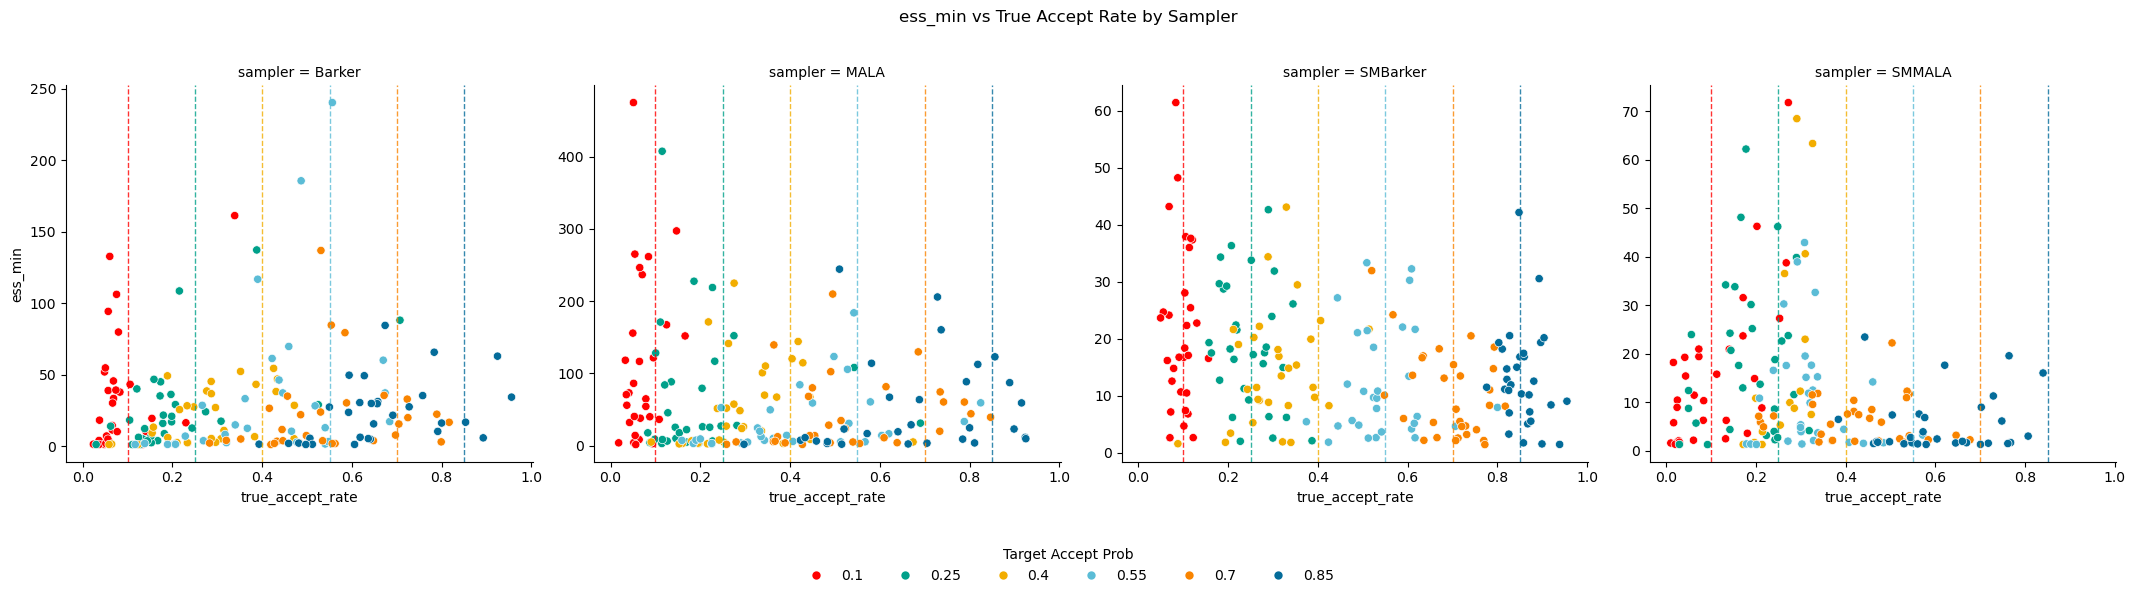

In [79]:
# Your custom palette and data
custom_palette = ["#FF0000", "#00A08A", "#F2AD00", "#5BBCD6", "#F98400", "#046C9A"]

# Get sorted unique values to match with palette
unique_probs = sorted(df["target_accept_prob"].unique())
color_map = dict(zip(unique_probs, custom_palette))  # Maps value → color

metrics = ["ad_max", "ks_max", "ess_min"]

for metric in metrics:
    g = sns.relplot(
        data=df,
        x="true_accept_rate",
        y=metric,
        hue="target_accept_prob",
        col="sampler",
        kind="scatter",
        palette=custom_palette,
        facet_kws={"sharex": True, "sharey": False},
    )

    # Add color-matching vertical lines
    for ax in g.axes.flat:
        for prob in unique_probs:
            ax.axvline(
                x=prob, color=color_map[prob], linestyle="--", linewidth=1, alpha=0.8
            )

    # Extract the actual legend object
    handles, labels = g.axes[0][0].get_legend_handles_labels()
    g._legend.remove()  # Remove default legend

    # Add horizontal legend at the bottom
    g.fig.legend(
        handles,
        labels,
        title="Target Accept Prob",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(unique_probs),  # Put all in one row
        frameon=False,
    )

    for text in g._legend.texts:
        text.set_fontsize("small")

    g.fig.suptitle(f"{metric} vs True Accept Rate by Sampler", y=1.02)
    plt.tight_layout()
    plt.show()

In [80]:
averages = (
    df.groupby(["sampler", "target_accept_prob"])[
        ["true_accept_rate", "ad_max", "ks_max", "ess_min"]
    ]
    .mean()
    .reset_index()
)

# Display the resulting DataFrame
averages

,sampler,target_accept_prob,true_accept_rate,ad_max,ks_max,ess_min
0,Barker,0.10,0.083297,0.507090,0.507090,35.990357
1,Barker,0.25,0.202404,0.487460,0.487460,27.149231
2,Barker,0.40,0.276680,0.473235,0.473235,20.841428
3,Barker,0.55,0.396930,0.460333,0.460333,35.229028
4,Barker,0.70,0.549266,0.444523,0.444523,21.708702
5,Barker,0.85,0.659605,0.464232,0.464232,23.464490
6,MALA,0.10,0.069318,0.646603,0.646603,108.136586
7,MALA,0.25,0.194988,0.618855,0.618855,69.960545
8,MALA,0.40,0.302747,0.594440,0.594440,56.205272
9,MALA,0.55,0.411624,0.560805,0.560805,33.793539


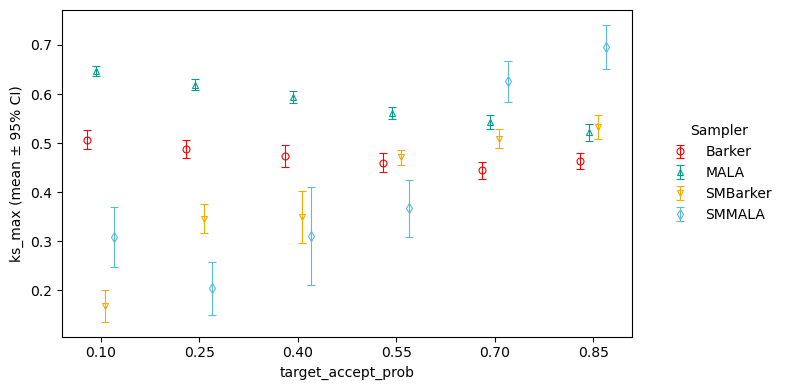

In [103]:
def mean_ci_95(series):
    mean = series.mean()
    sem = series.std(ddof=1) / np.sqrt(len(series))
    return mean, 1.96 * sem  # normal approx


# Compute grouped stats
grouped = (
    df.groupby(["sampler", "target_accept_prob"], group_keys=False)
    .apply(
        lambda g: pd.Series(
            {
                "ks_max_mean": mean_ci_95(g["ks_max"])[0],
                "ks_max_ci": mean_ci_95(g["ks_max"])[1],
            }
        ),
        include_groups=False,  # <- explicitly exclude grouping columns
    )
    .reset_index()
)

# -------------------------------
# Step 2: Plotting
# -------------------------------

# Plot settings
palette = ["#FF0000", "#00A08A", "#F2AD00", "#5BBCD6", "#F98400", "#046C9A"]
markers = ["o", "^", "v", "d"]

unique_taps = sorted(grouped["target_accept_prob"].unique())
unique_samplers = grouped["sampler"].unique()
n_samplers = len(unique_samplers)

base_x = np.arange(len(unique_taps)) * 1.5
dodge_width = 0.2
offsets = np.linspace(-dodge_width, dodge_width, n_samplers)

fig, ax = plt.subplots(figsize=(8, 4))

for i, sampler in enumerate(unique_samplers):
    sub = (
        grouped[grouped["sampler"] == sampler]
        .set_index("target_accept_prob")
        .reindex(unique_taps)
    )
    xvals = base_x + offsets[i]

    # Drop NaNs to avoid x/y length mismatch
    ax.errorbar(
        xvals[~sub["ks_max_mean"].isna()],
        sub["ks_max_mean"].dropna(),
        yerr=sub["ks_max_ci"].dropna(),
        marker=markers[i % len(markers)],
        fillstyle="none",
        linestyle="none",
        color=palette[i % len(palette)],
        capsize=3,
        label=sampler,
        markeredgewidth=0.8,
        linewidth=0.8,
        markersize=5,
    )

# Set custom ticks to match target_accept_prob values
ax.set_xticks(base_x)
ax.set_xticklabels([f"{tap:.2f}" for tap in unique_taps])
ax.set_xlabel("target_accept_prob")
ax.set_ylabel("ks_max (mean ± 95% CI)")

# Legend to the right
ax.legend(
    title="Sampler",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.0,
    frameon=False,
)

plt.tight_layout()
plt.show()